The workshop contains three different notebooks. Each one focuses on a different stage:
    
1. Dataset Generation. The first notebook focuses on generating a dataset for training the model. We will create a Robust Test Suite to check that the dataset generated meets certain conditions
2. Model Training. The second notebook focuses on training the model. We will create a Robust Test Suite to check that the trained model meets certain conditions.
3. Model Inference (This Notebook). In the last notebook, we use mercury.monitoring to monitor data drift and estimate the predicted performance of the model without having the labels

In [1]:
import pandas as pd
import numpy as np
from joblib import load
import pickle

from sklearn.metrics import accuracy_score

SEED = 23

## Load Model

In [2]:
!ls models

features.pkl model.joblib


In [3]:
path_dataset = "./models/"

model = load(path_dataset + 'model.joblib') 

with open(path_dataset + "features.pkl", "rb") as fp:
    features = pickle.load(fp)
    
label = "default.payment.next.month"

## Load Original Dataset 

We load the original training dataset, so we can use it for data drift detection

In [4]:
path_dataset = "./dataset/"

df_train = pd.read_csv(path_dataset + "train.csv")
df_test = pd.read_csv(path_dataset + "test.csv")

X_train = df_train[features]
X_test = df_test[features]

y_train = df_train[label]
y_test = df_test[label]

## Model Inference

Now, we load the `uci_credit_drifted_inference.csv` which we suppose that contains the data that we receive at inference time. It contains a column "time" which indicates the time that we receive the data. We will check two different timesteps: time=2 and time=9

In [5]:
# Load Dataset for specific time
df = pd.read_csv("data/uci_credit_drifted_inference.csv")
df_t2 = df[df["time"] == 2]
df_t9 = df[df["time"] == 9]

In [6]:
print(df_t2.shape)
print(df_t9.shape)

(1000, 27)
(1000, 27)


In [7]:
# Get Features and Labels
y_true_t2 = df_t2[label]
X_t2 = df_t2[features]

y_true_t9 = df_t9[label]
X_t9 = df_t9[features]

# Get Model predictions
y_pred_proba_train = model.predict_proba(X_train)

y_pred_t2 = model.predict(X_t2)
y_pred_proba_t2 = model.predict_proba(X_t2)

y_pred_t9 = model.predict(X_t9)
y_pred_proba_t9 = model.predict_proba(X_t9)

## Drift Detection

Now, we will use [mercury.monitoring](https://bbva.github.io/mercury-monitoring/) for data drift detection. We will use the [`KSDrift`](https://bbva.github.io/mercury-monitoring/reference/drift/#mercury.monitoring.drift.ks_drift_detector.KSDrift) and the [`DomainClassifierDrift`](https://bbva.github.io/mercury-monitoring/reference/drift/#mercury.monitoring.drift.domain_classifier_drift_detector.DomainClassifierDrift), although there are more detectors available that can be used

In [8]:
from mercury.monitoring.drift.ks_drift_detector import KSDrift
from mercury.monitoring.drift.domain_classifier_drift_detector import DomainClassifierDrift

### KS Drift

Let's start using the `KSDrift`. This detector performs a Kolmogorov-Smirnov (KS) test individually for each specified variable.

We can see that drift is not detected in time=2:

In [9]:
drift_detector = KSDrift(X_train.to_numpy(), X_t2.to_numpy(), features=features, p_val=0.01)
drift_metrics = drift_detector.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  0.02525962
Is drift detected?  False


Now, let's look at time=9

In [10]:
drift_detector = KSDrift(X_train.to_numpy(), X_t9.to_numpy(), features=features, p_val=0.01)
drift_metrics = drift_detector.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  0.034059323
Is drift detected?  True


Now drift is detected and the score is higher. We can also obtain which are the features with drift and plot them:

In [11]:
drift_detector.get_drifted_features()


['PAY_0']

<AxesSubplot:title={'center':'feature drift scores'}>

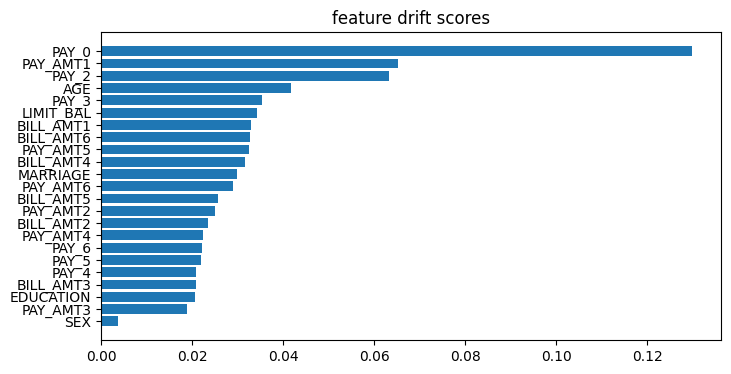

In [12]:
drift_detector.plot_feature_drift_scores()

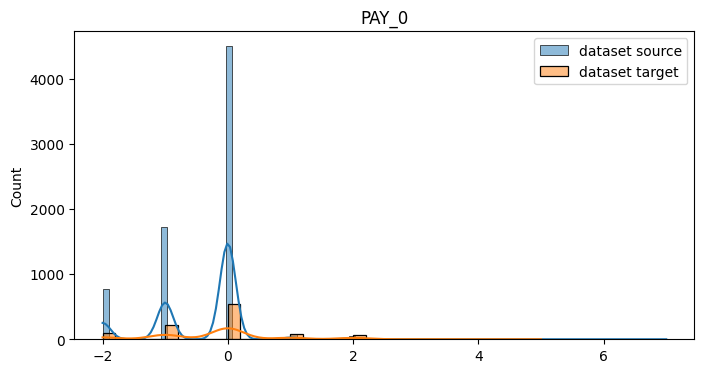

In [13]:
drift_detector.plot_distribution_drifted_features()

### Domain Classifier

Now we use the `DomainClassifierDrift`. This component trains a classifier (Random Forest) to distinguish between a source dataset and a target dataset. The performance of the model detecting which sample belongs to each dataset (ROC-AUC) is then used to indicate if drift is detected and as drift score.

In [14]:
drift_detector = DomainClassifierDrift(
    X_train.to_numpy(), X_t2.to_numpy(), features=features, p_val=0.05, n_runs=5
)
drift_metrics = drift_detector.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  0.510364160049821
Is drift detected?  False


We see that drift is not detected at time=2. Let's check at time=9:

In [15]:
drift_detector = DomainClassifierDrift(
    X_train.to_numpy(), X_t9.to_numpy(), features=features, p_val=0.05, n_runs=20
)
drift_metrics = drift_detector.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  0.5535341740619648
Is drift detected?  True


<AxesSubplot:title={'center':'feature drift scores'}>

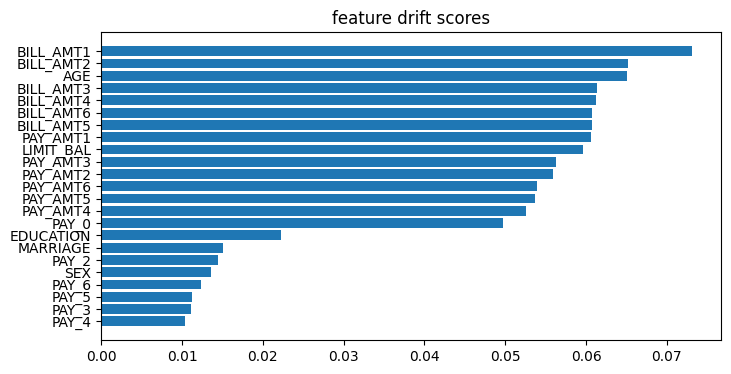

In [16]:
drift_detector.plot_feature_drift_scores()

### Drift in Predictions

In [17]:
drift_detector = KSDrift(y_pred_proba_train, y_pred_proba_t2, p_val=0.01)
drift_metrics = drift_detector.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  0.020815697
Is drift detected?  False


In [18]:
drift_detector = KSDrift(y_pred_proba_train, y_pred_proba_t9, p_val=0.01)
drift_metrics = drift_detector.calculate_drift()
print("Drift Score: ", drift_metrics["score"])
print("Is drift detected? ", drift_metrics["drift_detected"])

Drift Score:  0.05950806
Is drift detected?  True


## Accuracy Estimation

We will use now the [`PerformancePredictor`](https://bbva.github.io/mercury-monitoring/reference/estimation/#mercury.monitoring.estimation.performance_predictor.PerformancePredictor) component to estimate the accuracy of the model in a particular timestep without having the labels.

The component is based on the method presented in [Learning to Validate the Predictions of
Black Box Classifiers on Unseen Data](https://ssc.io/pdf/mod0077s.pdf)

Let's load the the `DataSchema` which we will use in the `PerformancePredictor` 

In [19]:
# Load Data Schema
from mercury.dataschema import DataSchema
schema = DataSchema.load(path_dataset + "schema.json")

# We won't need this for the PerformancePredictor
del schema.feats['default.payment.next.month']

Now let's estimate the Performance on timetep=9

In [20]:
from mercury.monitoring.estimation.performance_predictor import PerformancePredictor

# Create PerfomancePredictor
performance_predictor = PerformancePredictor(model, metric_fn=accuracy_score, random_state=SEED)
performance_predictor.fit(X=X_test, y=y_test, X_serving=X_t9, dataset_schema=schema)

In [21]:
predicted_acc = performance_predictor.predict(X_t9)
predicted_acc

array([0.61717337])

Since we have the labels in this case, we can compare it with the real performance:

In [22]:
# Real Accuracy
accuracy_score(y_true_t9, model.predict(X_t9))

0.645